<a href="https://colab.research.google.com/github/shanikairoshi/QFL_Experiments/blob/main/qfl_samplerqnn_fl_v1_6_autonomous_biomarker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QFL with SamplerQNN — v1.6 (with Pauli FM, MedMNIST, viz, benchmarking)

In [ ]:
!pip install "qiskit>=1.1" qiskit-aer qiskit-algorithms "qiskit-machine-learning>=0.7" qiskit-ibm-runtime \
                 scikit-learn pandas matplotlib numpy torch torchvision medmnist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

## 0) Dataset selector (real data + MedMNIST)
# Options: "synthetic", "iris", "wine", "breast_cancer", "mnist_pca",
#          "autonomous_sensorless", "biomarker_leukemia",
#          "medmnist_breast", "medmnist_pneumonia", "medmnist_oct", "medmnist_organA"
DATASET = "biomarker_leukemia"  # ← change hereFcl

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

def load_dataset(name="synthetic"):
    from sklearn.datasets import make_classification, load_iris, load_wine, load_breast_cancer, fetch_openml
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import numpy as np

    if name == "synthetic":
        X, y = make_classification(n_samples=600, n_features=4, n_informative=3,
                                   n_redundant=0, n_clusters_per_class=1, random_state=42)
        return X, y
    if name == "iris":
        ds = load_iris(); X, y = ds.data, ds.target
        y = (y==0).astype(int)  # setosa vs non
        return X[:,:4], y
    if name == "wine":
        ds = load_wine(); X, y = ds.data, ds.target
        y = (y==0).astype(int)
        return X[:,:4], y
    if name == "breast_cancer":
        ds = load_breast_cancer(); X, y = ds.data, ds.target
        X = StandardScaler().fit_transform(X)
        X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y
    if name == "mnist_pca":
        ds = fetch_openml("mnist_784", version=1, as_frame=False, parser="auto")
        X, y = ds.data, ds.target.astype(int)
        y = (y<=4).astype(int)  # 0-4 vs 5-9
        X = StandardScaler().fit_transform(X)
        X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y

    if name == "autonomous_sensorless":
        # Autonomous/vehicle-style signals dataset (tabular): OpenML 4536 "SensorlessDriveDiagnosis"
        # 48 features from motor current signals; original labels are 1..11 → we binarize as class "1" vs others
        ds = fetch_openml(data_id=4536, as_frame=True, parser="auto")
        X_df = ds.data if hasattr(ds, "data") else ds[0]
        if hasattr(X_df, "apply"):
            X_df = X_df.apply(pd.to_numeric, errors="coerce").fillna(0.0)
            X = X_df.to_numpy(dtype=np.float32)
        else:
            X = np.asarray(X_df, dtype=np.float32)

        y_raw = pd.Series(ds.target).astype(str).to_numpy()
        y = (y_raw == "1").astype(int)

        # Optional: subsample for faster quantum simulation
        max_n = 6000
        if len(y) > max_n:
            rng_local = np.random.default_rng(0)
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            n1 = min(len(idx1), max_n // 2)
            n0 = max_n - n1
            sel = np.concatenate([
                rng_local.choice(idx0, size=n0, replace=False),
                rng_local.choice(idx1, size=n1, replace=False),
            ])
            rng_local.shuffle(sel)
            X, y = X[sel], y[sel]

        X = StandardScaler().fit_transform(X)
        X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y

    if name == "biomarker_leukemia":
        # Biomarker / gene-expression dataset: OpenML 1104 "leukemia" (Golub et al.)
        # Labels typically ALL vs AML → we map AML=1, ALL=0
        ds = fetch_openml(data_id=1104, as_frame=True, parser="auto")
        X_df = ds.data if hasattr(ds, "data") else ds[0]
        if hasattr(X_df, "apply"):
            X_df = X_df.apply(pd.to_numeric, errors="coerce").fillna(0.0)
            X = X_df.to_numpy(dtype=np.float32)
        else:
            X = np.asarray(X_df, dtype=np.float32)

        y_raw = pd.Series(ds.target).astype(str).str.upper()
        y = (y_raw.str.contains("AML")).astype(int).to_numpy()

        X = StandardScaler().fit_transform(X)
        X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y
    if name == "medmnist_breast":
        from medmnist import BreastMNIST
        train = BreastMNIST(split='train', download=True, as_rgb=False)
        test  = BreastMNIST(split='test',  download=True, as_rgb=False)
        X = np.concatenate([train.imgs, test.imgs], axis=0).astype('float32')/255.0
        y = np.concatenate([train.labels, test.labels], axis=0).reshape(-1)
        X = X.reshape(len(X), -1)
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        X = StandardScaler().fit_transform(X); X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y
    if name == "medmnist_pneumonia":
        from medmnist import PneumoniaMNIST
        train = PneumoniaMNIST(split='train', download=True, as_rgb=False)
        test  = PneumoniaMNIST(split='test',  download=True, as_rgb=False)
        X = np.concatenate([train.imgs, test.imgs], axis=0).astype('float32')/255.0
        y = np.concatenate([train.labels, test.labels], axis=0).reshape(-1)
        X = X.reshape(len(X), -1)
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        X = StandardScaler().fit_transform(X); X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y
    if name == "medmnist_oct":
        from medmnist import OCTMNIST
        train = OCTMNIST(split='train', download=True, as_rgb=False)
        test  = OCTMNIST(split='test',  download=True, as_rgb=False)
        X = np.concatenate([train.imgs, test.imgs], axis=0).astype('float32')/255.0
        y = np.concatenate([train.labels, test.labels], axis=0).reshape(-1)
        y = (y==0).astype(int)  # class0 vs others
        X = X.reshape(len(X), -1)
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        X = StandardScaler().fit_transform(X); X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y
    if name == "medmnist_organA":
        from medmnist import OrganAMNIST
        train = OrganAMNIST(split='train', download=True, as_rgb=False)
        test  = OrganAMNIST(split='test',  download=True, as_rgb=False)
        X = np.concatenate([train.imgs, test.imgs], axis=0).astype('float32')/255.0
        y = np.concatenate([train.labels, test.labels], axis=0).reshape(-1)
        y = (y==0).astype(int)  # class0 vs others
        X = X.reshape(len(X), -1)
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA
        X = StandardScaler().fit_transform(X); X = PCA(n_components=4, random_state=0).fit_transform(X)
        return X, y

    raise ValueError("Unknown dataset option.")

# Load & standardize
X, y = load_dataset(DATASET)
X = (X - X.mean(0)) / X.std(0)
from numpy.random import default_rng
rng = default_rng(7)

def non_iid_split(X, y, num_clients=3):
    idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    predefined_ratios = np.array([0.6, 0.3, 0.1]) # Ratios defined for up to 3 clients
    num_available_ratios = len(predefined_ratios)

    if num_clients > num_available_ratios:
        print(f"Warning: The `non_iid_split` function has predefined ratios for a maximum of {num_available_ratios} clients. "
              f"Requested {num_clients} clients. Only {num_available_ratios} clients will be created with non-iid data. "
              f"To support more clients with non-iid splits, update the `predefined_ratios` array in `non_iid_split` function.")
        effective_num_clients = num_available_ratios
    else:
        effective_num_clients = num_clients

    ratios = predefined_ratios[:effective_num_clients]
    ratios = ratios / ratios.sum() # Normalize ratios so they sum to 1

    n0 = (ratios * len(idx0)).astype(int)
    n1 = (ratios * len(idx1)).astype(int)

    # Distribute any remaining elements due to integer conversion evenly
    remaining_0 = len(idx0) - np.sum(n0)
    if remaining_0 > 0:
        for _ in range(remaining_0):
            n0[rng.integers(effective_num_clients)] += 1

    remaining_1 = len(idx1) - np.sum(n1)
    if remaining_1 > 0:
        for _ in range(remaining_1):
            n1[rng.integers(effective_num_clients)] += 1

    splits = []; s0 = s1 = 0
    for i in range(effective_num_clients): # Loop for the effective number of clients
        sl0 = idx0[s0:s0+n0[i]]; sl1 = idx1[s1:s1+n1[i]]
        s0 += n0[i]; s1 += n1[i]
        ids = np.concatenate([sl0, sl1]); rng.shuffle(ids)
        splits.append((X[ids], y[ids]))
    return splits

clients_data = non_iid_split(X, y, num_clients=10)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print(f"Loaded dataset: {DATASET}, shapes — X: {X.shape}, y: {y.shape}")

Loaded dataset: biomarker_leukemia, shapes — X: (72, 4), y: (72,)


In [ ]:

## 1) Feature maps (Z, ZZ, ZX, Pauli)
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def z_feature_map(num_features: int) -> QuantumCircuit:
    qc = QuantumCircuit(num_features)
    x = ParameterVector('x', num_features)
    for i in range(num_features):
        qc.ry(x[i], i)
    return qc

def zz_feature_map(num_features: int) -> QuantumCircuit:
    qc = z_feature_map(num_features)
    for i in range(num_features-1):
        qc.cz(i, i+1)
    if num_features > 1:
        qc.cz(num_features-1, 0)
    return qc

def zx_feature_map(num_features: int) -> QuantumCircuit:
    qc = QuantumCircuit(num_features)
    x = ParameterVector('x', num_features)
    for i in range(num_features):
        qc.ry(x[i], i); qc.rx(0.5*x[i], i)
    for i in range(num_features-1):
        qc.cx(i, i+1)
    return qc

# Pauli feature map helper (new API, fallback to old class, else custom)
def pauli_feature_map_qiskit(num_qubits: int, paulis=('Z','ZZ'), reps: int = 1):
    try:
        from qiskit.circuit.library import pauli_feature_map as _pfm
        return _pfm(num_qubits=num_qubits, paulis=list(paulis), reps=reps)
    except Exception:
        try:
            from qiskit.circuit.library import PauliFeatureMap as _PFM
            return _PFM(feature_dimension=num_qubits, paulis=list(paulis), reps=reps)
        except Exception:
            qc = QuantumCircuit(num_qubits)
            x = ParameterVector('x', num_qubits)
            for j in range(num_qubits):
                qc.rz(x[j], j)
            if 'ZZ' in paulis and num_qubits > 1:
                for j in range(num_qubits-1):
                    qc.cz(j, j+1)
                qc.cz(num_qubits-1, 0)
            return qc

FEATURE_MAPS = {
    "Z": z_feature_map,
    "ZZ": zz_feature_map,
    "ZX": zx_feature_map,
    "pauli": lambda n: pauli_feature_map_qiskit(n, paulis=('Z','ZZ'), reps=1),
}


In [ ]:

## 2) Ansatz (TwoLocal, RealAmplitudes, EfficientSU2)
from qiskit.circuit.library import TwoLocal, RealAmplitudes, EfficientSU2

def build_variational_ansatz(n_qubits: int, reps: int = 1, ansatz_type: str = "TwoLocal"):
    at = ansatz_type.lower()
    if at == "twolocal":
        return TwoLocal(num_qubits=n_qubits, rotation_blocks=["ry"], entanglement_blocks="cz", reps=reps, insert_barriers=False)
    elif at == "realamplitudes":
        return RealAmplitudes(num_qubits=n_qubits, reps=reps, entanglement="full")
    elif at == "efficientsu2":
        return EfficientSU2(num_qubits=n_qubits, reps=reps, entanglement="linear")
    else:
        raise ValueError(f"Unknown ansatz type: {ansatz_type}")


In [ ]:

## 3) Config dataclass
from dataclasses import dataclass
@dataclass
class QNNConfig:
    n_qubits: int = 4
    feature_map_name: str = "ZZ"     # "Z","ZZ","ZX","pauli"
    ansatz_reps: int = 1
    ansatz_type: str = "TwoLocal"    # "TwoLocal","RealAmplitudes","EfficientSU2"


## 4) SamplerQNN + TorchConnector + Federated clients

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorSampler as Sampler # Updated import for V2 Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

def parity(x): return f"{x:b}".count("1") % 2

def make_sampler_qnn(cfg: QNNConfig):
    fmap = FEATURE_MAPS[cfg.feature_map_name](cfg.n_qubits)
    ans = build_variational_ansatz(cfg.n_qubits, cfg.ansatz_reps, cfg.ansatz_type)
    model = fmap.compose(ans)
    qnn = SamplerQNN(circuit=model,
                     input_params=model.parameters[:cfg.n_qubits],
                     weight_params=model.parameters[cfg.n_qubits:],
                     sampler=Sampler(), interpret=parity, output_shape=2) # Use StatevectorSampler instance
    return qnn

class TorchQNN_Sampler(nn.Module):
    def __init__(self, cfg: QNNConfig):
        super().__init__()
        qnn = make_sampler_qnn(cfg)
        self.connector = TorchConnector(qnn)

    def forward(self, x):
        out = self.connector(x)
        if out.ndim == 1: out = torch.stack([1-out, out], dim=1)
        return out

class ClientTorch:
    def __init__(self, X, y, cfg: QNNConfig, lr=0.05):
        self.device = torch.device('cpu')
        self.X = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.y = torch.tensor(y, dtype=torch.long).to(self.device)
        self.model = TorchQNN_Sampler(cfg).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.CrossEntropyLoss()

    def set_weights(self, sd): self.model.load_state_dict(sd)
    def get_weights(self): return {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}

    def train_one_epoch(self, batch_size=32):
        self.model.train()
        idx = torch.randperm(self.X.size(0))
        for s in range(0, self.X.size(0), batch_size):
            idb = idx[s:s+batch_size]
            xb, yb = self.X[idb], self.y[idb]
            self.optimizer.zero_grad()
            logits = self.model(xb)
            loss = self.loss_fn(logits, yb)
            loss.backward(); self.optimizer.step()

    @torch.no_grad()
    def evaluate(self, X, y):
        self.model.eval()
        X = torch.tensor(X, dtype=torch.float32)
        logits = self.model(X)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        return accuracy_score(y, preds)


## 5) Run Federated Learning

In [ ]:

cfg = QNNConfig(n_qubits=4, feature_map_name="pauli", ansatz_reps=1, ansatz_type="TwoLocal")
clients = [ClientTorch(Xi, yi, cfg, lr=0.05) for (Xi, yi) in clients_data]

global_state = clients[0].get_weights()
for cl in clients: cl.set_weights(global_state)

history = []
for rnd in range(5):
    local_states = []
    for cl in clients:
        cl.train_one_epoch(batch_size=32)
        local_states.append(cl.get_weights())
    new_state = {k: sum(sd[k] for sd in local_states)/len(local_states) for k in global_state}
    global_state = new_state
    for cl in clients: cl.set_weights(global_state)
    accs = [cl.evaluate(X_val, y_val) for cl in clients]
    history.append({"round": rnd, "val_acc_mean": float(np.mean(accs))})

import pandas as pd
hist_df = pd.DataFrame(history)
hist_df.to_csv("samplerqnn_fl_history_v1_6.csv", index=False)
hist_df


/tmp/ipython-input-2232125495.py:37: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the pauli_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  return _PFM(feature_dimension=num_qubits, paulis=list(paulis), reps=reps)
/tmp/ipython-input-2270740507.py:7: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  return TwoLocal(num_qubits=n_qubits, rotation_blocks=["ry"], entanglement_blocks="cz", reps=reps, insert_barriers=False)
/tmp/ipython-input-2232125495.py:37: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiski

,round,val_acc_mean
0,0,0.469136
1,1,0.481481
2,2,0.469136
3,3,0.469136
4,4,0.475309


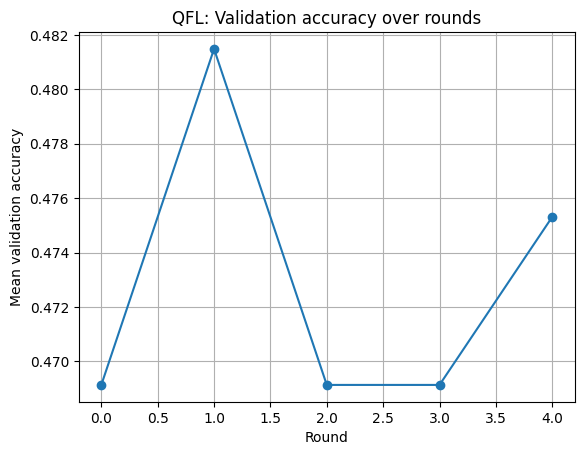

<Figure size 640x480 with 0 Axes>

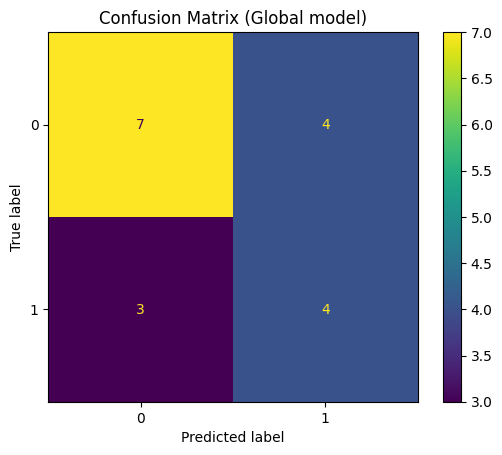

Test accuracy (global): 0.6111111111111112


In [ ]:

## 6) Visualization — accuracy over rounds
import matplotlib.pyplot as plt, pandas as pd
if 'hist_df' in globals():
    plt.figure(); plt.plot(hist_df['round'], hist_df['val_acc_mean'], marker='o')
    plt.xlabel('Round'); plt.ylabel('Mean validation accuracy'); plt.title('QFL: Validation accuracy over rounds')
    plt.grid(True); plt.show()
else:
    print("Run the FL loop above first to create hist_df.")

## 6b) Confusion matrix on test set
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torch
if 'clients' in globals() and len(clients)>0:
    clients[0].model.eval()
    Xt = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        logits = clients[0].model(Xt)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    cm = confusion_matrix(y_test, preds, labels=np.unique(y_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    import matplotlib.pyplot as plt
    plt.figure(); disp.plot(values_format='d'); plt.title('Confusion Matrix (Global model)'); plt.show()
    print("Test accuracy (global):", accuracy_score(y_test, preds))
else:
    print("Run the FL loop first.")


/tmp/ipython-input-2270740507.py:7: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  return TwoLocal(num_qubits=n_qubits, rotation_blocks=["ry"], entanglement_blocks="cz", reps=reps, insert_barriers=False)
/tmp/ipython-input-2270740507.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  return RealAmplitudes(num_qubits=n_qubits, reps=reps, entanglement="full")
/tmp/ipython-input-2270740507.py:11: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  return EfficientSU2(num_qubits=n_q

,feature_map,ansatz_type,mean_val_acc_last,best_mean_val_acc,test_acc,wall_time_s,label
0,Z,EfficientSU2,0.851852,0.851852,0.666667,1123.661194,Z:EfficientSU2
1,Z,RealAmplitudes,0.870370,0.870370,0.777778,548.046652,Z:RealAmplitudes
2,Z,TwoLocal,0.870370,0.932099,0.777778,583.313554,Z:TwoLocal
3,ZX,EfficientSU2,0.851852,0.851852,0.777778,1197.470563,ZX:EfficientSU2
4,ZX,RealAmplitudes,0.845679,0.870370,0.777778,593.683841,ZX:RealAmplitudes
5,ZX,TwoLocal,0.858025,0.858025,0.722222,599.924116,ZX:TwoLocal
6,ZZ,EfficientSU2,0.864198,0.870370,0.833333,1158.716835,ZZ:EfficientSU2
7,ZZ,RealAmplitudes,0.796296,0.796296,0.722222,572.064074,ZZ:RealAmplitudes
8,ZZ,TwoLocal,0.808642,0.827160,0.833333,570.671640,ZZ:TwoLocal
9,pauli,EfficientSU2,0.771605,0.783951,0.666667,1363.081957,pauli:EfficientSU2


Saved summary to /content/drive/MyDrive/qfl_results/QFLBasicExperimentScaled/qfl_benchmark_results_v1_6_biomarker_Leukemia.csv


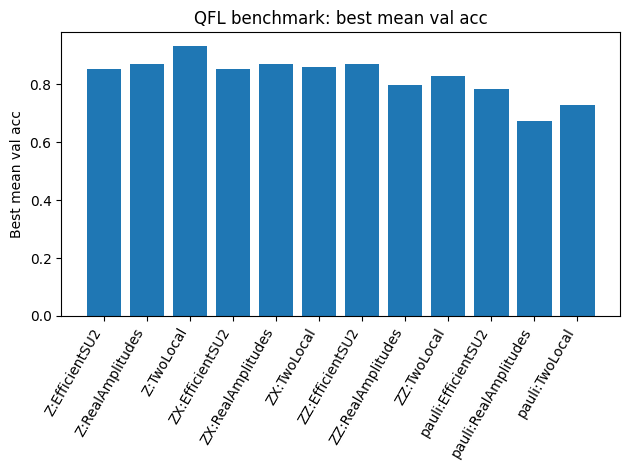

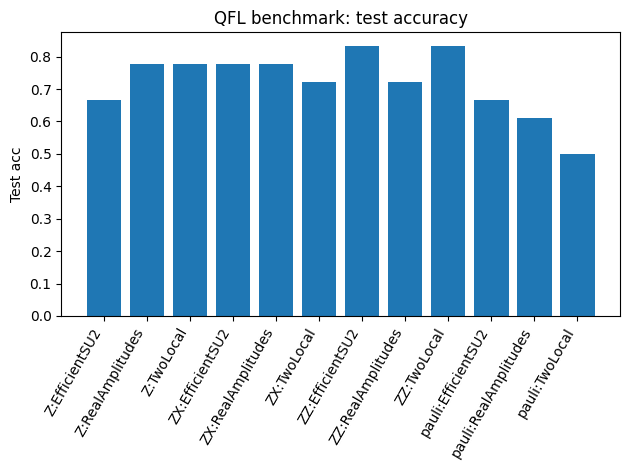

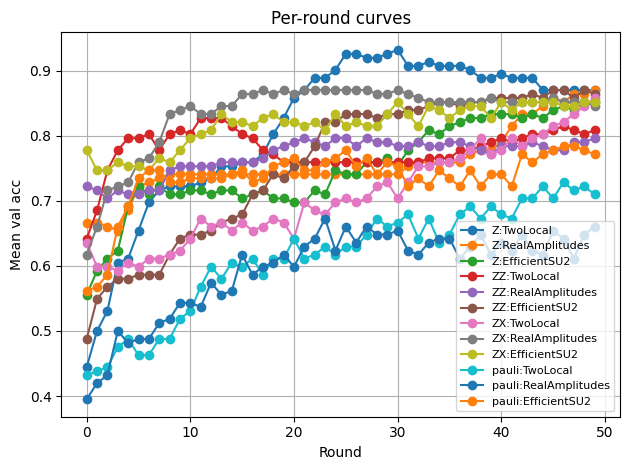

In [ ]:

import os
import pandas as pd
## 7) One-shot benchmarking (single run over multiple configs)
import time, itertools, pandas as pd, numpy as np
import matplotlib.pyplot as plt

FEATURES   = ["Z", "ZZ", "ZX", "pauli"]
ANSAETZES  = ["TwoLocal", "RealAmplitudes", "EfficientSU2"]
QNN_TYPES  = ["sampler"]  # in Estimator notebook, change to ["estimator"] or ["sampler","estimator"]
ROUNDS     = 50
LR         = 0.05

def run_fl_once(build_client_fn, rounds=ROUNDS):
    t0 = time.time()
    clients = [build_client_fn(cd) for cd in clients_data]
    global_state = clients[0].get_weights()
    for cl in clients: cl.set_weights(global_state)
    round_means = []
    for rnd in range(rounds):
        local_states = []
        for cl in clients:
            cl.train_one_epoch(batch_size=32)
            local_states.append(cl.get_weights())
        new_state = {k: sum(sd[k] for sd in local_states)/len(local_states) for k in global_state}
        global_state = new_state
        for cl in clients: cl.set_weights(global_state)
        accs = [cl.evaluate(X_val, y_val) for cl in clients]
        round_means.append(float(np.mean(accs)))
    import torch
    clients[0].model.eval()
    Xt = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        logits = clients[0].model(Xt)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    from sklearn.metrics import accuracy_score
    test_acc = accuracy_score(y_test, preds)
    return round_means, test_acc, time.time() - t0

rows, curves = [], []
for fm in FEATURES:
  for at in ANSAETZES:
    label = f"{fm}:{at}"
    cfg = QNNConfig(n_qubits=4, feature_map_name=fm, ansatz_reps=1, ansatz_type=at)
    build_client = lambda d, cfg=cfg: ClientTorch(d[0], d[1], cfg, lr=LR)
    rc, test_acc, elapsed = run_fl_once(build_client, rounds=ROUNDS)
    rows.append({"feature_map": fm, "ansatz_type": at,
                 "mean_val_acc_last": rc[-1], "best_mean_val_acc": max(rc),
                 "test_acc": test_acc, "wall_time_s": elapsed, "label": label})
    curves.append({"label": label, "curve": rc})

bench_df = pd.DataFrame(rows).sort_values(["feature_map","ansatz_type"]).reset_index(drop=True)
display(bench_df)

# 1) Choose a folder in your Google Drive
#    Example: /content/drive/MyDrive/qfl_results/
drive_folder = "/content/drive/MyDrive/qfl_results/QFLBasicExperimentScaled"

# 2) Create the folder if it does not exist
os.makedirs(drive_folder, exist_ok=True)

# 3) Full path inside Drive
csv_path = os.path.join(drive_folder, "qfl_benchmark_results_v1_6_biomarker_Leukemia.csv")

# 4) Save to Drive
bench_df.to_csv(csv_path, index=False)
print(f"Saved summary to {csv_path}")

plt.figure(); plt.bar(bench_df["label"], bench_df["best_mean_val_acc"]); plt.xticks(rotation=60, ha="right")
plt.ylabel("Best mean val acc"); plt.title("QFL benchmark: best mean val acc"); plt.tight_layout(); plt.show()

plt.figure(); plt.bar(bench_df["label"], bench_df["test_acc"]); plt.xticks(rotation=60, ha="right")
plt.ylabel("Test acc"); plt.title("QFL benchmark: test accuracy"); plt.tight_layout(); plt.show()

plt.figure()
for c in curves: plt.plot(range(ROUNDS), c["curve"], marker="o", label=c["label"])
plt.xlabel("Round"); plt.ylabel("Mean val acc"); plt.title("Per-round curves"); plt.grid(True); plt.legend(fontsize=8); plt.tight_layout(); plt.show()
